In [1]:
import numpy as np
import pathlib as pl
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
current_path    = pl.Path.cwd().parent.joinpath('img', '01 - Original')
select_folder   = 1 # 1: train, 2: test
folder_path     = current_path.joinpath('train' if select_folder == 1 else 'test')

images_path     = folder_path.joinpath('ims')
mask_path       = folder_path.joinpath('masks')
images_list     = list(images_path.glob('*.npy'))
mask_list       = list(mask_path.glob('*.npy'))

#create a new folder for the Denoised images
new_folder_path = current_path.parent.joinpath('02 -Denoised').mkdir(exist_ok=True)
output_path     = current_path.parent.joinpath('02 -Denoised')

In [3]:
def sorting_key(filepath):
    parts           = filepath.stem.split('_')  # Divide el nombre del archivo en partes
    patient_number  = int(parts[1])  # Extrae el número del paciente
    slice_number    = int(parts[2])  # Extrae el número del slice
    return (patient_number, slice_number)  # Retorna una tupla con ambos números

# Ordena images_list basado en el número del paciente y el número del slice
images_list.sort(key=sorting_key)
mask_list.sort(key=sorting_key)

In [4]:
def generar_imagenes_png(images_list, mask_list, cmap='gray', output_path=output_path):
    """
    Display images and masks side by side.
    
    Parameters:
    - images_list: List of paths to image files.
    - mask_list: List of paths to mask files.
    - cmap: Color map for displaying images and masks. Default is 'gray'.
    
    Returns:
    - None
    """

    for image, mask in tqdm(zip(images_list, mask_list), desc='Displaying images and masks'):
        parts = image.stem.split('_')
        set_folder = parts[0]
        pacient = int(parts[1])
        slice_number = int(parts[2])
        # Cargar datos de imagen y máscara
        image_data = np.load(image)
        mask_data = np.load(mask)
        
        # Crear subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        # Mostrar imagen
        ax1.imshow(image_data, cmap=cmap)
        ax1.set_title(f'Imagen: {image.stem}')
        ax1.axis('off')
        
        # Mostrar máscara
        ax2.imshow(mask_data, cmap=cmap)
        ax2.set_title(f'Máscara: {mask.stem}')
        ax2.axis('off')
        
        # Añadir un súper título con la información del paciente
        fig.suptitle(f'Paciente: {pacient}', fontsize=16)
        
        # Guardar imagen en output_path
        plt.savefig(output_path.joinpath(f'{image.stem}.png'))
        plt.close()

# prueba


In [5]:
number=100
name = mask_list[number].stem

mask_file = np.load(mask_list[number])

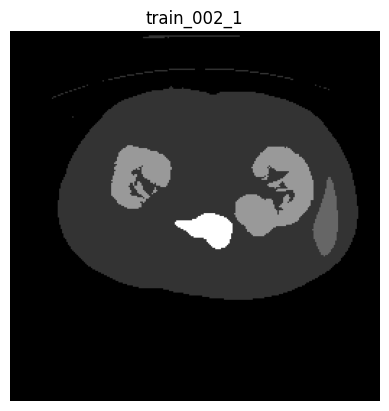

In [6]:
import matplotlib.pyplot as plt

plt.imshow(mask_file, cmap='gray')
plt.title(f'{name}')
plt.axis('off')
plt.show()

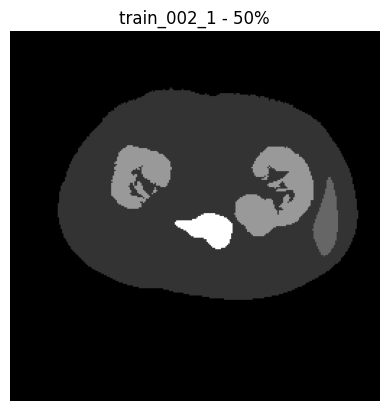

In [7]:

m_percentage = 50

for i in range(int(np.floor(mask_file.shape[0]*m_percentage/100)), 0-1, -1):
    column_sums = np.sum(mask_file[:i,:] == 1, axis=0)
    columns_to_replace = np.where((column_sums <= 3) & (column_sums > 0))[0]
    for col in columns_to_replace:
        mask_file[:i, col] = np.where(mask_file[:i, col] == 1, 0, mask_file[:i, col])

plt.imshow(mask_file, cmap='gray')
plt.title(f'{name} - {m_percentage}%')
plt.axis('off')
plt.show()

In [8]:
def remove_noise(m_percentage, files_images,files_masks,value_image,value_mask,select_folder,output_path):
    folder_path = output_path.joinpath('train' if select_folder == 1 else 'test').mkdir(exist_ok=True)
    folder_path = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('ims').mkdir(exist_ok=True)
    folder_path = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('masks').mkdir(exist_ok=True)
    image_path = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('ims')
    mask_path = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('masks')

    for image, mask in tqdm(zip(files_images, files_masks), desc='Removing noise'):
        name = mask.stem
        image_data = np.load(image)
        mask_data = np.load(mask)

        for i in range(int(np.floor(mask_data.shape[0]*m_percentage/100)), 0-1, -1):
            column_sums = np.sum(mask_data[:i,:] == 1, axis=0)
            columns_to_replace = np.where((column_sums <= 3) & (column_sums > 0))[0]
            for col in columns_to_replace:
                mask_data[:i, col] = np.where(mask_data[:i, col] == 1, 0, mask_data[:i, col])
        np.save(mask_path.joinpath(name), mask_data)

        for i in range(image_data.shape[0]):
            for j in range(image_data.shape[1]):
                if mask_data[i,j] == value_mask:
                    image_data[i,j] = value_image
        
        np.save(image_path.joinpath(name), image_data)


In [ ]:
def remove_noise(m_percentage, files_images, files_masks, value_image, value_mask, select_folder, output_path):
    """
    Removes noise from images based on mask data.

    Parameters:
    m_percentage (float): Percentage of the mask to be considered for noise removal.
    files_images (list): List of paths to image files.
    files_masks (list): List of paths to corresponding mask files.
    value_image (int): Value to assign to the image in the noise areas.
    value_mask (int): Value in the mask to identify noise areas.
    select_folder (int): Selector for train/test folder. Use 1 for 'train', else 'test'.
    output_path (Path): Base path for the output files.

    Returns:
    None: The function saves the processed images and masks to the specified output path.
    """

    # Ensure output_path is a Path object
    output_path = Path(output_path)

    # Define the subdirectories
    subfolder = 'train' if select_folder == 1 else 'test'
    image_path = output_path.joinpath(subfolder, 'ims')
    mask_path = output_path.joinpath(subfolder, 'masks')

    # Create necessary directories
    image_path.mkdir(parents=True, exist_ok=True)
    mask_path.mkdir(parents=True, exist_ok=True)

    for image, mask in tqdm(zip(files_images, files_masks), desc='Removing noise'):
        name = mask.stem
        try:
            # Load the image and mask data
            image_data = np.load(image)
            mask_data = np.load(mask)

            # Noise removal from mask
            for i in range(int(np.floor(mask_data.shape[0]*m_percentage/100)), -1, -1):
                column_sums = np.sum(mask_data[:i, :] == 1, axis=0)
                columns_to_replace = np.where((column_sums <= 3) & (column_sums > 0))[0]
                mask_data[:i, columns_to_replace] = np.where(mask_data[:i, columns_to_replace] == 1, 0, mask_data[:i, columns_to_replace])

            # Save the processed mask
            np.save(mask_path.joinpath(name), mask_data)

            # Applying changes to image based on mask
            image_data[mask_data == value_mask] = value_image

            # Save the processed image
            np.save(image_path.joinpath(name), image_data)

        except Exception as e:
            print(f"Error processing {name}: {e}")

# Train Folder

In [9]:
remove_noise(50, images_list,mask_list,-1024,0,1,output_path) # Train with ims and masks

Removing noise: 2725it [03:44, 12.14it/s]


In [11]:
remove_noise(50, images_list,mask_list,-1024,0,2,output_path) # Test with ims and masks

Removing noise: 2725it [04:36,  9.87it/s]


In [10]:
images_path = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('ims')
mask_path   = output_path.joinpath('train' if select_folder == 1 else 'test').joinpath('masks')
images_list = list(images_path.glob('*.npy'))
mask_list   = list(mask_path.glob('*.npy'))
images_list.sort(key=sorting_key)
mask_list.sort(key=sorting_key)

number=200
generar_imagenes_png(images_list[:number], mask_list[:number], cmap='gray', output_path=output_path)
print(images_list)
print('Done!')

Displaying images and masks: 200it [00:23,  8.47it/s]

[WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_0.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_1.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_2.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_3.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_4.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_5.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_6.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_7.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/02 -Denoised/train/ims/train_000_8.npy'), WindowsPath('d:/Trabajo de Maestria/segmentacion_maestria/img/0